In [63]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [64]:
def set_constants():
    velocity = 1.0
    time_step = 0.1
    max_control = 1.0
    weight1 = 0.5
    weight2 = 0.5
    prediction_horizon = 10
    return velocity, time_step, max_control, weight1, weight2, prediction_horizon


In [65]:

def get_system_matrices(velocity, time_step):
    state_matrix = np.array([[1, 0], [velocity * time_step, 1]])
    control_matrix = np.array([[time_step], [0.5 * velocity * time_step**2]])
    return state_matrix, control_matrix


In [66]:

def define_variables(control_horizon):
    control_inputs = [cp.Variable() for _ in range(control_horizon)]
    states = [cp.Variable(2) for _ in range(control_horizon + 1)]
    return control_inputs, states


In [67]:

def accumulate_cost(states, control_inputs, step, weight1, weight2, total_cost):
    total_cost += weight1 * cp.abs(states[step][1]) + weight2 * cp.abs(states[step][0]) + cp.abs(control_inputs[step])
    return total_cost

In [68]:

def define_constraints(states, control_inputs, step, state_matrix, control_matrix, max_control, constraint_list):
    constraint_list.append(states[step + 1] == state_matrix @ states[step] + control_matrix @ cp.reshape(control_inputs[step], (1,)))
    constraint_list.append(cp.abs(control_inputs[step]) <= max_control)


In [69]:

def solve_optimization(total_cost, constraint_list, initial_state):
    constraint_list.append(states[0] == initial_state)
    opt_problem = cp.Problem(cp.Minimize(total_cost), constraint_list)
    opt_problem.solve()
    return opt_problem

In [70]:
def get_solution(opt_problem, control_inputs, states):
    if opt_problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        optimal_controls = np.array([ctrl.value for ctrl in control_inputs])
        optimal_states = np.array([state.value for state in states])
        return optimal_controls, optimal_states
    else:
        return None, None

In [74]:

def visualize_results(optimal_u, optimal_x, dt, horizon):
    # Extract the angle and position from the optimal states
    optimal_x = np.array(optimal_x)
    angle_opt = optimal_x[:, 0]
    position_opt = optimal_x[:, 1]
    
    # Time vectors for state and control trajectories
    time_states = np.arange(horizon + 1) * dt  # One extra for state
    time_controls = np.arange(horizon) * dt  # Matches control actions
    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    
    # Plot the optimal angle trajectory
    axes[0].plot(time_states, angle_opt, marker='o')
    axes[0].set_title('Optimal Angle Trajectory')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Angle (a)')
    
    # Plot the optimal position trajectory
    axes[1].plot(time_states, position_opt, marker='x', color='r')
    axes[1].set_title('Optimal Position Trajectory')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Position (y)')
    
    # Plot the optimal control inputs
    axes[2].bar(time_controls, optimal_u, width=dt / 2, color='g')
    axes[2].set_title('Optimal Control Inputs')
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Control Input (u)')
    
    # Adjust layout for better spacing
    plt.tight_layout(pad=4.0)
    plt.subplots_adjust(hspace=0.4)
    plt.show()


Optimal control inputs: [-7.44184868e-24  2.26398560e-24  2.34247015e-24 -2.43048299e-24
 -5.79003765e-25 -2.72710916e-24  1.76064012e-24  1.66596890e-24
 -3.39843485e-25 -1.68662358e-25]
Optimal state trajectory: [[-1.38807953e-22  7.13158267e-21]
 [-3.88724753e-23  1.57249670e-21]
 [ 2.41948147e-23  1.09330118e-22]
 [ 4.48661256e-23 -1.95394180e-22]
 [ 4.56888986e-23 -2.05500293e-22]
 [ 3.96662224e-23 -1.57951907e-22]
 [ 3.16961845e-23 -1.12127012e-22]
 [ 2.54292492e-23 -7.72238339e-23]
 [ 2.01842939e-23 -5.42165295e-23]
 [ 1.66636469e-23 -3.98003684e-23]
 [ 1.40728800e-23 -3.23834707e-23]]


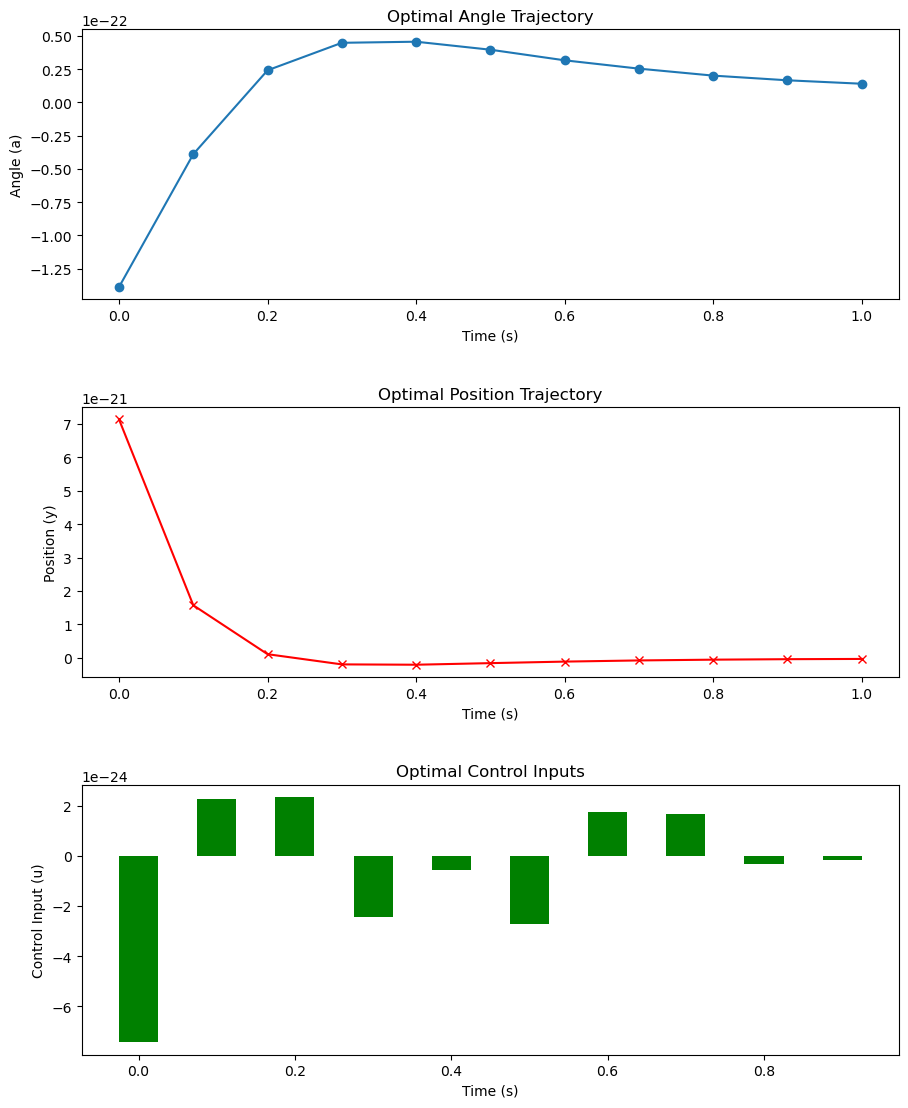

In [75]:
# Set constants
velocity, time_step, max_control, weight1, weight2, prediction_horizon = set_constants()

# Get system matrices
state_matrix, control_matrix = get_system_matrices(velocity, time_step)

# Define variables
control_horizon = prediction_horizon
control_inputs, states = define_variables(control_horizon)

# Initialize objective function and constraints list
total_cost = 0
constraint_list = []

# Iterate over control steps
for step in range(control_horizon):
    # Accumulate cost function terms
    total_cost = accumulate_cost(states, control_inputs, step, weight1, weight2, total_cost)
    # Define constraints
    define_constraints(states, control_inputs, step, state_matrix, control_matrix, max_control, constraint_list)

# Add terminal cost
total_cost += weight1 * cp.abs(states[control_horizon][1]) + weight2 * cp.abs(states[control_horizon][0])

# Set initial state condition
initial_state = np.array([0, 0])  # Adjust as necessary

# Solve optimization problem
opt_problem = solve_optimization(total_cost, constraint_list, initial_state)

# Get and print solution
optimal_controls, optimal_states = get_solution(opt_problem, control_inputs, states)
if optimal_controls is not None and optimal_states is not None:
    print("Optimal control inputs:", optimal_controls)
    print("Optimal state trajectory:", optimal_states)
    visualize_results(optimal_controls, optimal_states, time_step, control_horizon)
else:
    print('Unable to solve the optimization problem')
